# Sentiment analysis

In this notebook, we will apply the DistillBERT sentiment analysis model to the clean dataset and save the result. 

### Imports

In [1]:
import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Add the project root directory (not src) to sys.path
sys.path.append(os.path.abspath("../data/"))

# Now import the DataLoader class
from data_loading import DataLoader

raw = '../../data/RAW/'
clean = '../../data/CLEAN'

In [3]:
# Add the directory containing the script to sys.path
sys.path.append(os.path.abspath("../model"))

# Now you can import the script like a module
import DistillBERT_emotion

/Users/djay/miniforge3/envs/ada/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load the data

In [4]:
#load raw data
data_loader = DataLoader(raw,clean)

#are we working on the test set
Test_set_data = True
#run everything again ? 
Run = False

if Test_set_data :
    MovieData = data_loader.plot_data()
    MovieName = data_loader.movie_data()["Movie name"]
    ViolentLabel, ViolentData = data_loader.human_labelled_data()
    MovieData = MovieData.loc[ViolentData.index.unique()]
    MovieData = pd.merge(MovieData,MovieName, left_index=True, right_index=True,how="inner")
else :
    MovieData = data_loader.clean_movie_data()


load plot data


load CMU movie metadata



In [5]:
MovieData.head()

,Plot,Movie name
Wikipedia movie ID,,
19286405,Panakkara Kudumbam is a movie about how human ...,Panakkara Kudumbam
6714641,After serving time for the attempted murder of...,Deadly Intentions... Again?
27573594,Natsuki is a blind girl on whose testimony Tak...,Obscene Stalker: It Holds in Darkness!
25874731,Mistakenly believing that his brother-in-law's...,Talk of the Town Tora-san
34954266,"The genesis and metamorphoses of a film, from ...",Le Temps d'un film


## distillBERT sentiment analysis

In [6]:

if Run :
    # Lists to accumulate rows for efficiency
    sentiment_data = []
    
    detector = DistillBERT_emotion.ViolenceDetector()
    i = 0
    for index,row in MovieData.iterrows():
        if i%1000 ==0:
            print(i)
        result = detector.analyze_violence(row["Plot"])
    
        sentiment_data.append({
                "Wikipedia movie ID": index,
                "name" : row["Movie name"],
                "sadness": result[0],
                "joy": result[1],
                "love": result[2],
                "anger": result[3],
                "fear": result[4],
                "surprise": result[5]
            })
        i += 1
    
    Sentiment = pd.DataFrame(sentiment_data)

In [7]:
if Run : 
    # save the result
    if Test_set_data : 
        Sentiment.to_csv(clean + "/sentiment_test.csv") 
    else : 
        Sentiment.to_csv(clean + "/sentiment.csv") 
else :
    SentimentData,SentimentDataTest = data_loader.load_sentiment()
    if Test_set_data :
        Sentiment = SentimentDataTest
    else :
        Sentiment = SentimentData
    
    

In [8]:
Sentiment =Sentiment.set_index("Wikipedia movie ID")
Sentiment.head()

,name,sadness,joy,love,anger,fear,surprise
Wikipedia movie ID,,,,,,,
19286405,Panakkara Kudumbam,0.058061,0.003358,0.000692,0.934285,0.003266,0.000338
6714641,Deadly Intentions... Again?,0.001600,0.001495,0.000530,0.940499,0.055357,0.000519
27573594,Obscene Stalker: It Holds in Darkness!,0.009460,0.008160,0.001356,0.060288,0.918628,0.002107
25874731,Talk of the Town Tora-san,0.060930,0.006543,0.001101,0.264932,0.665094,0.001399
34954266,Le Temps d'un film,0.029678,0.011213,0.000931,0.030358,0.923933,0.003888


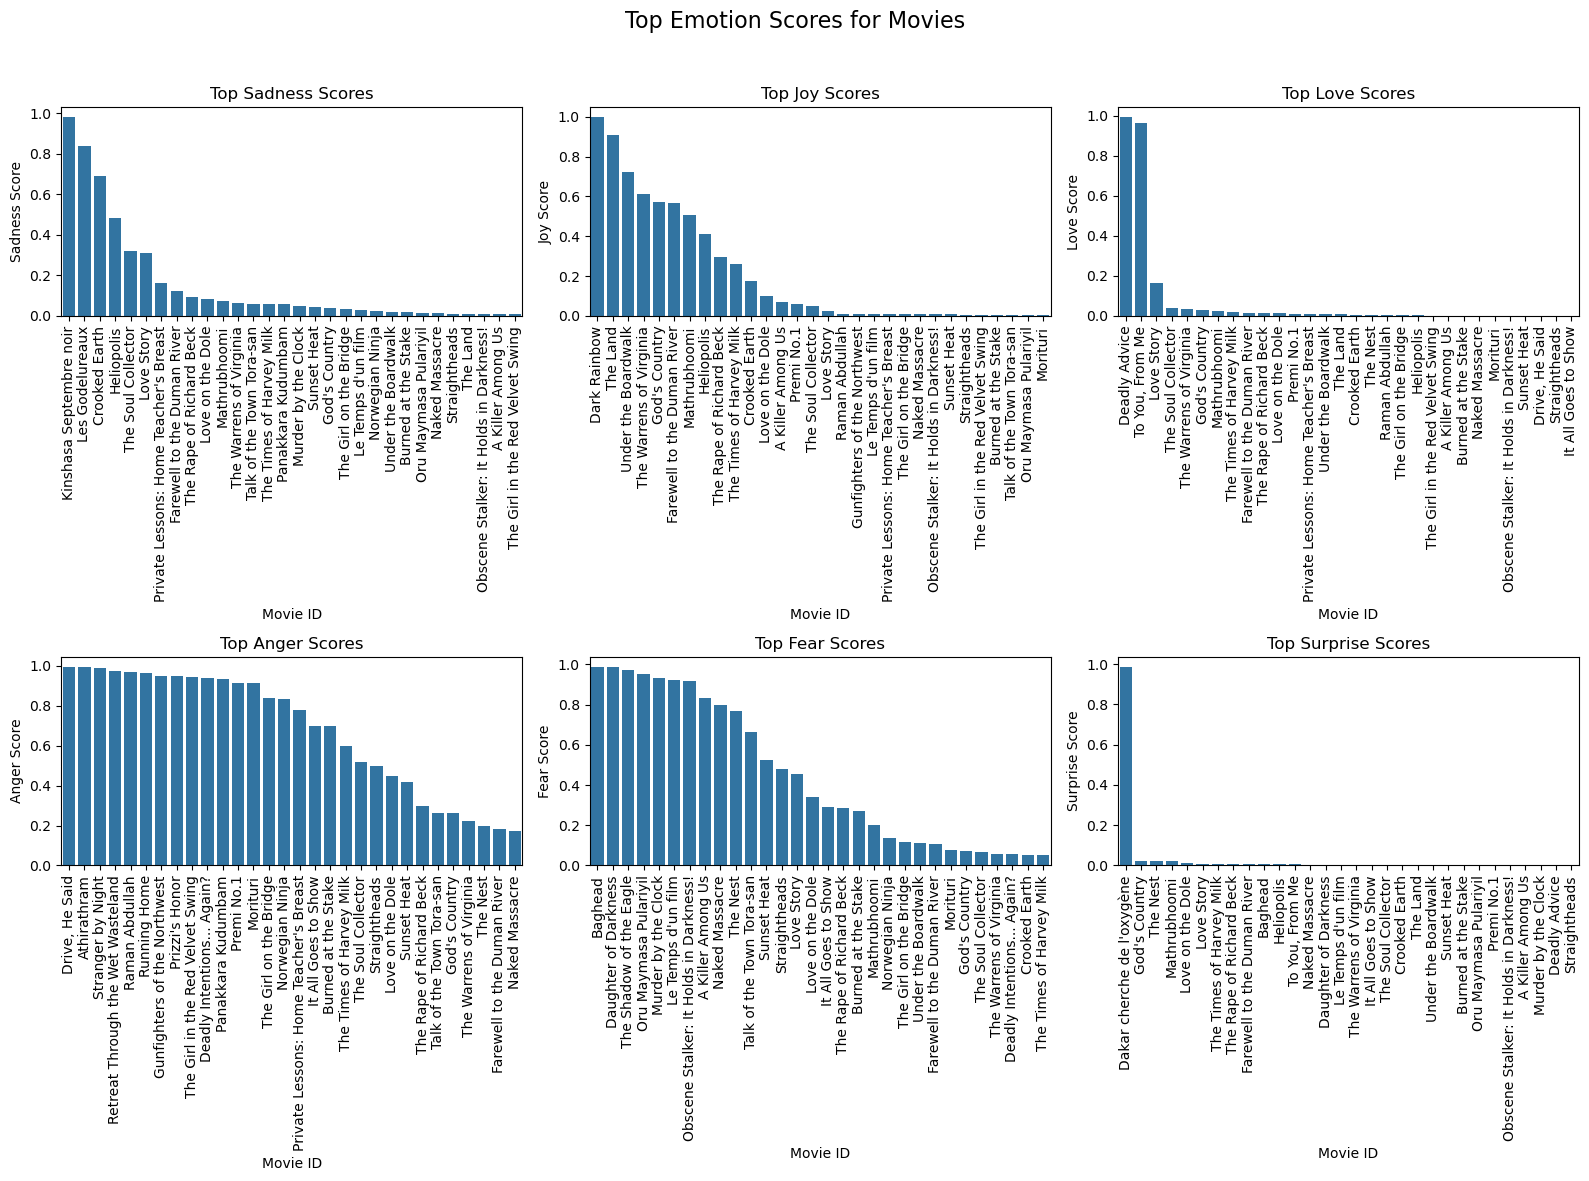

In [9]:
X = 30
emotions = ["sadness",
            "joy",
            "love",
            "anger",
            "fear",
            "surprise"]

# Create a figure with subplots (1x3 grid)
fig, axes = plt.subplots(2, 3, figsize=(16,12))

# Set a title for the entire figure
fig.suptitle('Top Emotion Scores for Movies', fontsize=16)

for i in range(0,len(emotions)):
    
    # Plot for Sadness with vertical x labels
    sns.barplot(x='name', y=emotions[i], data=Sentiment.sort_values(emotions[i],ascending=False).iloc[0:min(X,Sentiment.shape[0])],ax=axes[i//3, i%3])
    axes[i//3, i%3].set_title(f'Top {emotions[i].capitalize()} Scores')
    axes[i//3, i%3].set_xlabel('Movie ID')
    axes[i//3, i%3].set_ylabel(f'{emotions[i].capitalize()} Score')

    axes[i//3, i%3].set_xticks(range(min(X,Sentiment.shape[0])))  # Ensure ticks are set
    axes[i//3, i%3].set_xticklabels(axes[i//3, i%3].get_xticklabels(), rotation=90)


# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout to fit suptitle
plt.show()
